# 0. Setup

In [1]:
import nilearn
import pandas as pd
import numpy as np
import os

from nilearn import plotting
from nilearn import connectome
from nilearn import datasets
from nilearn import image



In [2]:
# Set the path to the data directory
src_dir = '../data'

# Set the participant and session IDs
part_id = 'sub-01'
ses_id = 'ses-01'

# Path to the T1w image
anat_path = os.path.join(src_dir, part_id, ses_id, 'anat', f'{part_id}_{ses_id}_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')

# Path to functional image
funcdir_path = os.path.join(src_dir, part_id, ses_id, 'func')

## 0.1 Anat

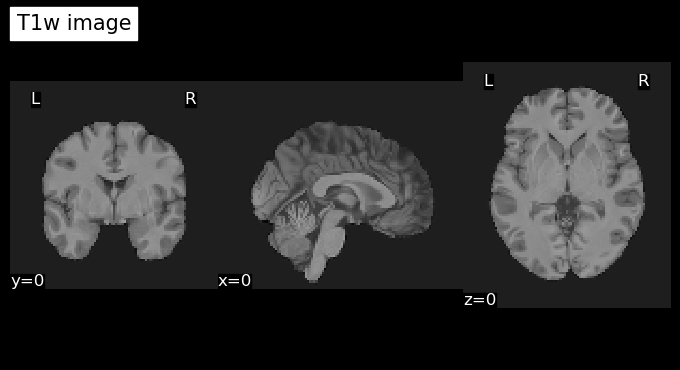

In [3]:
from nilearn.plotting import plot_anat

plot_anat(anat_path, title='T1w image', display_mode='ortho',  draw_cross=False,  cut_coords=(0, 0, 0))


In [32]:
# load the functional data

# list directory contents with extension 'nii.gz'
func_runs = os.listdir(funcdir_path)
func_runs = [f for f in func_runs if f.endswith('bold.nii.gz')]

# Sort the list
func_runs.sort()

print(func_runs)

['sub-01_ses-01_task-02a_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-01_ses-01_task-02a_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-01_ses-01_task-02a_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-01_ses-01_task-02a_run-4_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz']


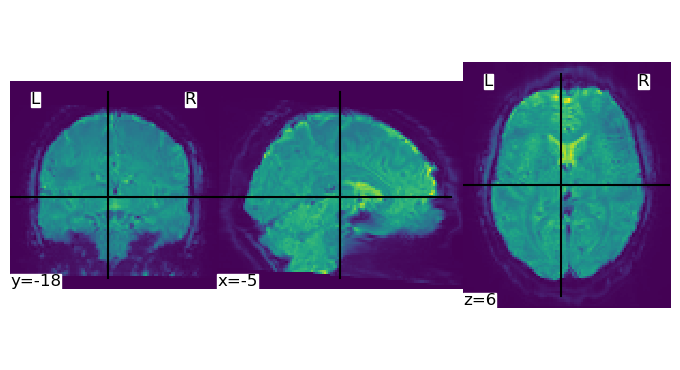

In [33]:
from nilearn.image import mean_img , load_img
from nilearn.plotting import plot_img

# Load the first functional image
func_image = image.load_img(os.path.join(funcdir_path,func_runs[0]))

mfunc_img = mean_img(func_image)

plot_img(mfunc_img)

# 1. Load Mask / atlas / meta

['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Paracingulate

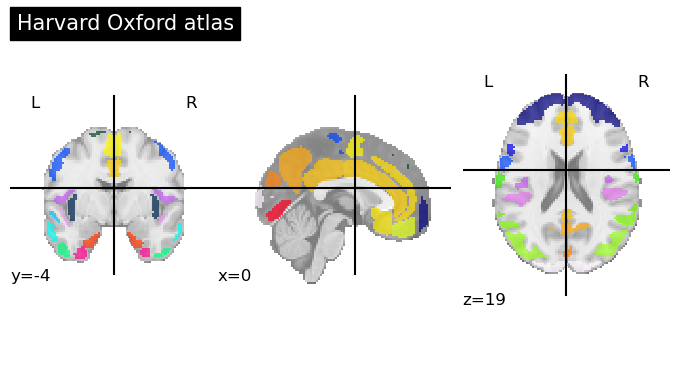

In [34]:
# load atlas
from nilearn import datasets
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm')
atlas_filename = atlas.maps

# list of labels
labels = atlas.labels

print(labels)

# number of regions
number_of_regions = len(labels[1:])
print(number_of_regions)

# plot the atlas
from nilearn import plotting
plotting.plot_roi(atlas_filename, title="Harvard Oxford atlas")

# 2. Extract timecourses per ROI / block

In [35]:
# extract time series from ROIs
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, memory='nilearn_cache')

# time_series = masker.fit_transform(func_image)


In [36]:
fdir_events = [file for file in os.listdir(funcdir_path) if file.endswith('.tsv')]

f_events = [os.path.join(funcdir_path, f) for f in fdir_events]

f_events.sort()

print(f_events)


['../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-1_events.tsv', '../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-2_events.tsv', '../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-3_events.tsv', '../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-4_events.tsv']


# 3. Compute connectivity

In [ ]:
from nilearn.image import index_img 


onset_set = {}
duration_set = {}

target_set = {}

group_set = {}


offset_st = 4 # offset for the onset time
offset_end = 2 # offset for the end block time

# Compute the correlation matrix and store it in the partial correlation matrix as a 4D array
conn_measure = connectome.ConnectivityMeasure(kind='correlation',
    standardize="zscore_sample",)

# intialize 2D array to store the partial correlation matrix 
partial_correlation_matrix = {}

run_id = 0
idx = 0

# for each events file 
for fn in f_events:

    print(os.path.join(funcdir_path,func_runs[run_id]), fn)

    # Load the events.tsv file
    events = pd.read_table(fn)

    # Load the corresponding functional image
    func_image = image.load_img(os.path.join(funcdir_path,func_runs[run_id]))

    # extract time course from functional image
    time_series = masker.fit_transform(func_image)

    # create one image per event 
    for i, row in events.iterrows():

        # Print the row information
        # print(row) 

        # Extract the onset time
        onset = np.round(row['onset'])

        # Extract the duration
        duration = np.round(row['duration'])

        # Extract the trial_type
        trial_type = row['trial_type']

        # Print the row information
        print(onset, duration, trial_type) 

        # if duration greater than 10 and not 'Noise'
        if duration > 10 and onset + duration + offset_end < 660 and trial_type != 'Noise':

            onset_set[idx] = onset + offset_st

            duration_set[idx] = duration - offset_st + offset_end

            target_set[idx] = trial_type

            group_set[idx] = run_id

            # Extract the time series for the event
            event_time_series = time_series[int(onset):int(onset + duration), :]

            
            # 2D array for the correlation matrix
            temp_correlation_matrix = conn_measure.fit_transform([event_time_series])[0]

            # vectorize the correlation matrix
            partial_correlation_matrix[idx] = temp_correlation_matrix.flatten()

            idx += 1

    run_id += 1

../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz ../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-1_events.tsv
0.0 12.0 Noise
12.0 24.0 Tenderness
36.0 6.0 Noise
42.0 24.0 Tenderness
66.0 18.0 Noise
84.0 24.0 Wonder
108.0 6.0 Noise
114.0 24.0 Wonder
138.0 18.0 Noise
156.0 24.0 Nostalgia
180.0 6.0 Noise
187.0 24.0 Nostalgia
210.0 18.0 Noise
228.0 24.0 Peacefulness
252.0 6.0 Noise
258.0 24.0 Peacefulness
282.0 18.0 Noise
300.0 24.0 Transcendence
324.0 6.0 Noise
330.0 24.0 Transcendence
354.0 18.0 Noise
372.0 24.0 Sadness
396.0 6.0 Noise
402.0 24.0 Sadness
426.0 18.0 Noise
444.0 24.0 Power
468.0 6.0 Noise
474.0 24.0 Power
498.0 18.0 Noise
516.0 24.0 Tension
540.0 6.0 Noise
546.0 24.0 Tension
570.0 18.0 Noise
588.0 24.0 JoyfulActivation
613.0 6.0 Noise
618.0 24.0 JoyfulActivation
642.0 18.0 Noise
../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz ../data/sub-01

## 3.1 Visualize average results per emotion

Sadness
10 Sadness 1
11 Sadness 2
20 Sadness 3
21 Sadness 4
36 Sadness 5
37 Sadness 6
54 Sadness 7
55 Sadness 8


Peacefulness
6 Peacefulness 1
7 Peacefulness 2
34 Peacefulness 3
35 Peacefulness 4
50 Peacefulness 5
51 Peacefulness 6
56 Peacefulness 7
57 Peacefulness 8
Tenderness
0 Tenderness 1
1 Tenderness 2
28 Tenderness 3
29 Tenderness 4
40 Tenderness 5
41 Tenderness 6
60 Tenderness 7
61 Tenderness 8
Power
12 Power 1
13 Power 2
26 Power 3
27 Power 4
44 Power 5
45 Power 6
66 Power 7
67 Power 8
Nostalgia
4 Nostalgia 1
5 Nostalgia 2
32 Nostalgia 3
33 Nostalgia 4
46 Nostalgia 5
47 Nostalgia 6
68 Nostalgia 7
69 Nostalgia 8
Tension
14 Tension 1
15 Tension 2
22 Tension 3
23 Tension 4
42 Tension 5
43 Tension 6
70 Tension 7
71 Tension 8
JoyfulActivation
16 JoyfulActivation 1
17 JoyfulActivation 2
24 JoyfulActivation 3
25 JoyfulActivation 4
38 JoyfulActivation 5
39 JoyfulActivation 6
64 JoyfulActivation 7
65 JoyfulActivation 8
Wonder
2 Wonder 1
3 Wonder 2
30 Wonder 3
31 Wonder 4
48 Wonder 5
49 Wonder 6
62 Wonder 7
63 Wonder 8
Transcendence
8 Transcendence 1
9 Transcendence 2
18 Transcendence 3
19 Transcen

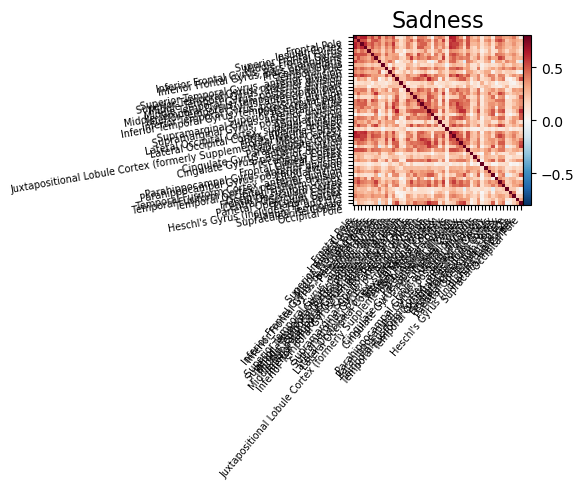

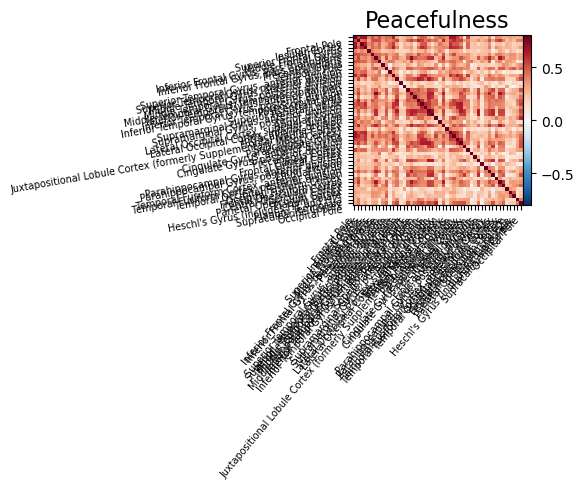

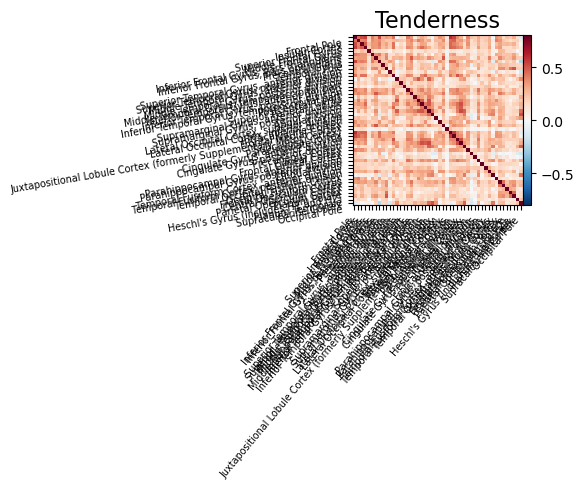

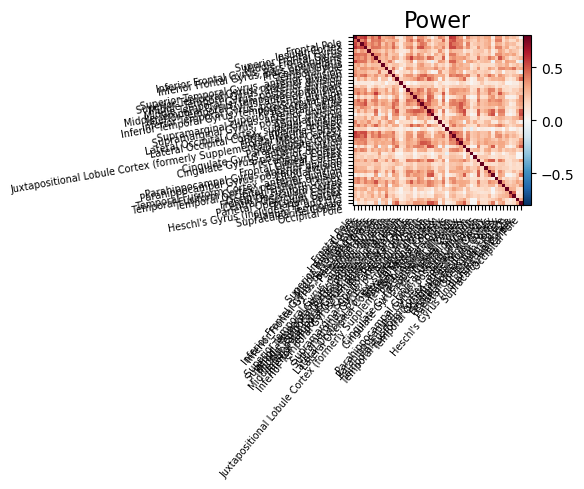

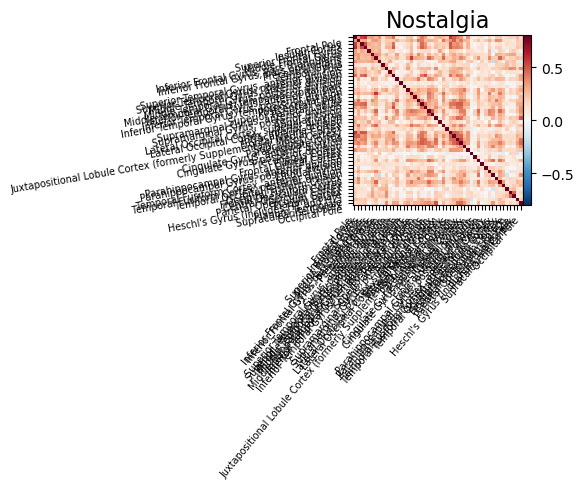

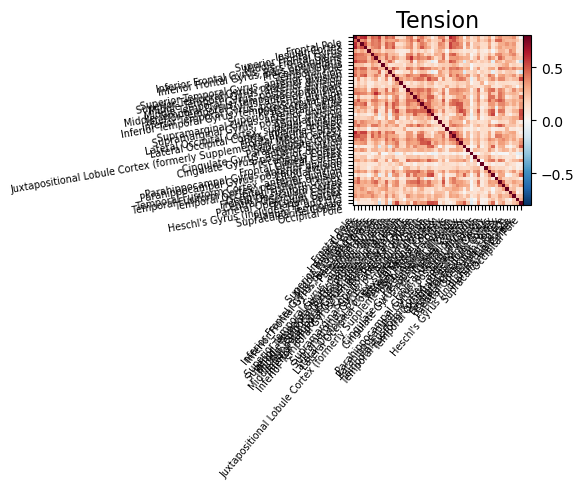

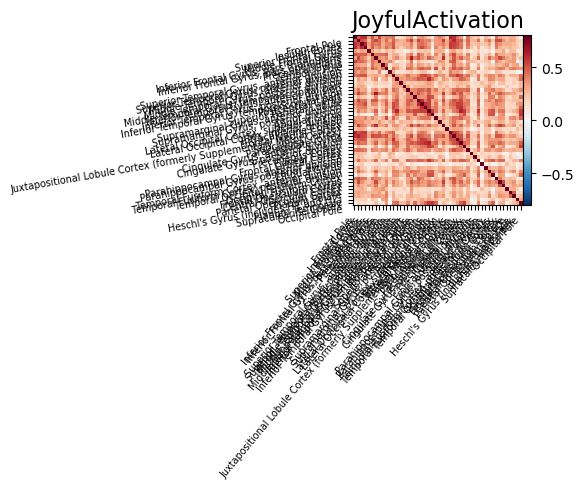

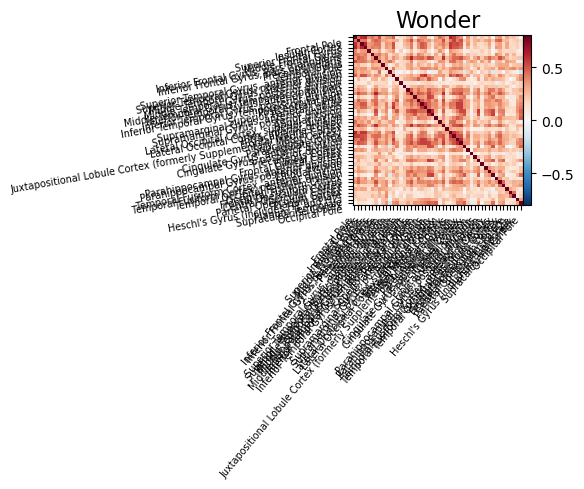

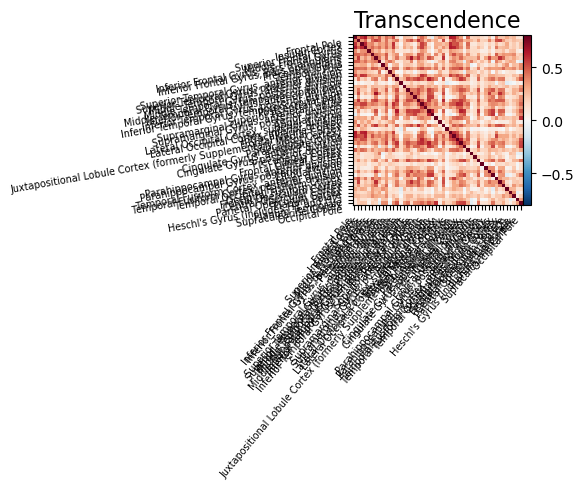

In [ ]:
# Visualize the average correlation matrix for each type of event

for target in set(target_set.values()):
    
    # print(target)

    # Normalize the correlation matrix

    # Get the number of events for the target
    counter = 0

    fl_correlation_matrix = np.zeros((number_of_regions * number_of_regions))

    for key, value in target_set.items():


        if value == target:
            fl_correlation_matrix += partial_correlation_matrix[key]
            counter += 1


    fl_correlation_matrix /= counter

    TwoD_correlation_matrix = fl_correlation_matrix.reshape(number_of_regions,number_of_regions)
    # Plot the correlation matrix
    plotting.plot_matrix(TwoD_correlation_matrix, labels=labels[1:], vmax=0.8, vmin=-0.8, title=target)


    # Save the correlation matrix as a nifti file
    correlation_matrix_img = masker.inverse_transform(TwoD_correlation_matrix)

    correlation_matrix_img.to_filename(f'correlation_matrix_{target}.nii.gz')



# 4. Compare emotions and save

In [97]:

# two-factorial anova analysis
# one factor is the type of event
# the other factor is the region

# create a dataframe to store the correlation matrix
df = pd.DataFrame(partial_correlation_matrix.values())

# add the target column
df['target'] = target_set.values()




In [98]:
# rename the columns
df.columns = [f'conn_{i}' for i in range(number_of_regions * number_of_regions)] + ['target']

In [99]:
df

,conn_0,conn_1,conn_2,conn_3,conn_4,conn_5,conn_6,conn_7,conn_8,conn_9,...,conn_2295,conn_2296,conn_2297,conn_2298,conn_2299,conn_2300,conn_2301,conn_2302,conn_2303,target
0,1.0,0.585926,0.621063,0.662167,0.510292,0.692480,0.658633,0.707915,0.464423,0.668195,...,0.503873,0.146363,0.319237,0.325453,0.511963,0.327684,0.233451,0.190992,1.0,Tenderness
1,1.0,0.459449,0.321975,0.477440,0.275569,0.382202,0.230174,0.455270,0.304217,0.103922,...,0.462074,-0.031612,-0.097077,-0.085583,-0.075124,-0.004160,-0.082631,0.316999,1.0,Tenderness
2,1.0,0.654383,0.771943,0.753131,0.611980,0.604159,0.628067,0.729051,0.284005,0.644924,...,0.810481,0.515854,0.662376,0.751097,0.502431,0.205147,0.303250,0.630037,1.0,Wonder
3,1.0,0.431177,0.407257,0.403873,0.250469,0.147987,0.283751,0.526234,0.139160,0.119971,...,0.449111,-0.024240,0.110848,0.311112,0.053666,0.098435,-0.213711,0.126521,1.0,Wonder
4,1.0,0.377196,0.369203,0.476202,0.153452,0.246899,0.266537,0.340191,0.094973,-0.063720,...,0.469295,0.120493,0.336921,0.109519,0.021485,0.094524,-0.044989,0.178752,1.0,Nostalgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1.0,0.375251,0.376160,0.453428,0.240145,0.325730,0.278683,0.401665,0.279852,-0.017088,...,0.329168,0.339050,0.306535,0.060609,-0.148761,-0.352151,-0.224226,0.190387,1.0,Power
68,1.0,0.522732,0.508494,0.607302,0.212187,0.456582,0.259254,0.134420,0.354485,0.433890,...,0.090204,0.269963,0.130959,0.289330,0.226222,0.087432,0.154818,0.147466,1.0,Nostalgia
69,1.0,0.402611,0.621846,0.626270,0.375107,0.442061,0.386207,0.392958,0.188901,0.343269,...,0.397506,0.300722,0.379768,0.309012,0.104881,0.037209,0.270385,0.243053,1.0,Nostalgia
70,1.0,0.583781,0.546407,0.629002,0.066982,0.499197,0.405107,0.411775,0.393127,0.382412,...,0.333051,0.050967,0.223222,0.268541,0.067076,-0.147077,0.272311,0.386409,1.0,Tension


In [100]:
# ANOVA analysis for each region

from statsmodels.formula.api import ols

from statsmodels.stats.anova import anova_lm

# create a dictionary to store the results
results = {}

df = df.rename(columns={0: "conn0"})

for i in range(number_of_regions * number_of_regions):
    
        # create the formula
        formula = f'conn_{i} ~ C(target)'
    
        # create the model
        model = ols(formula, data=df).fit()
    
        # perform the ANOVA
        aov_table = anova_lm(model, typ=2)
    
        # store the results
        results[i] = aov_table
    

/var/folders/nj/5_rdn90926779n4b6y3sbq9c0000gn/T/ipykernel_49081/625470305.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anova_matrix[i,j] = results[i * number_of_regions + j]['PR(>F)'][0]


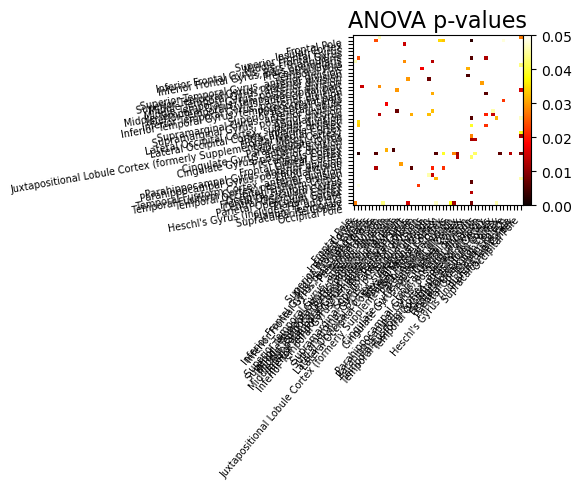

In [125]:
# transform the p-value results into a square matrix
anova_matrix = np.zeros((number_of_regions, number_of_regions))

for i in range(number_of_regions):
    for j in range(number_of_regions):
        anova_matrix[i,j] = results[i * number_of_regions + j]['PR(>F)'][0]

# Plot the p-values
plotting.plot_matrix(anova_matrix, labels=labels[1:], vmax=0.05, vmin=0, title='ANOVA p-values', cmap='hot')



# 5. Decoding

In [102]:
# feature selection

# select feature with p-value < 0.05
selected_features = np.where(anova_matrix.flatten() < 0.05)

print(selected_features)

(array([   7,   47,   54,   72,   73,   81,   90,  110,  289,  321,  325,
        336,  350,  358,  431,  451,  464,  560,  591,  597,  660,  674,
        679,  732,  767,  790,  805,  906,  921,  994, 1020, 1030, 1047,
       1063, 1072, 1077, 1093, 1095, 1137, 1144, 1151, 1153, 1201, 1233,
       1237, 1343, 1377, 1391, 1425, 1426, 1545, 1547, 1585, 1590, 1607,
       1609, 1612, 1613, 1618, 1625, 1628, 1631, 1652, 1661, 1665, 1741,
       1782, 1792, 1798, 1801, 1893, 1894, 1943, 1967, 2001, 2017, 2034,
       2145, 2256, 2264, 2271, 2279, 2283, 2284, 2289, 2296]),)


In [103]:
from nilearn.maskers import NiftiMasker
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut

from nilearn.decoding import Decoder
# “background”: Use this option if your images present a clear homogeneous background.
# “whole-brain-template”: This will extract the whole-brain part of your data by resampling 
# the MNI152 brain mask for your data’s field of view.


logo = LeaveOneGroupOut()

In [104]:
c_func_runs = [os.path.join(funcdir_path, f) for f in func_runs]

In [105]:
# Masking the data

from nilearn.masking import compute_epi_mask, compute_multi_epi_mask

mask_img = compute_multi_epi_mask(c_func_runs)

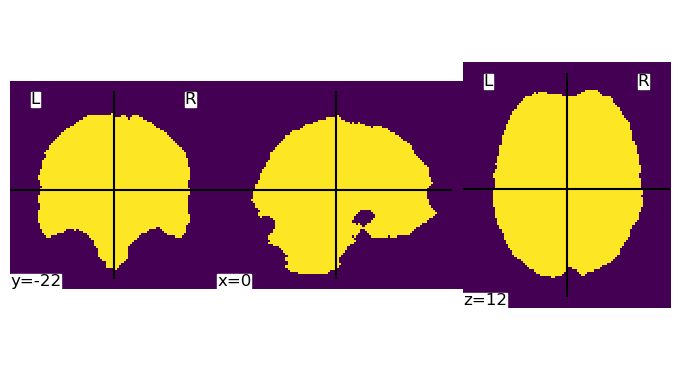

In [106]:
# plot mask image
plot_img(mask_img)

In [107]:
# Create the input matrix
X = np.array(list(partial_correlation_matrix.values()))

# Select the features
X = X[:, selected_features[0]]

In [108]:
X.shape

(72, 86)

In [109]:
y = list(target_set.values())

# transform the target_set unique strings to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# 0 agaisnt all others
# y = np.where(y == 1, 0, 1)

print(y)


[5 5 8 8 1 1 2 2 7 7 4 4 3 3 6 6 0 0 7 7 4 4 6 6 0 0 3 3 5 5 8 8 1 1 2 2 4
 4 0 0 5 5 6 6 3 3 1 1 8 8 2 2 7 7 4 4 2 2 7 7 5 5 8 8 0 0 3 3 1 1 6 6]


In [110]:
runs_group = list(group_set.values())

print(runs_group)

# unique values in runs_group
print(np.unique(runs_group))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[0 1 2 3]


### Scikit CV

In [111]:
from sklearn.model_selection import GroupKFold

# number of unique in runs_group
n_splits = len(np.unique(runs_group))

logo = LeaveOneGroupOut()

#for train, test in logo.split(X, y, groups=runs_group):

#    print("%s %s" % (train, test))

In [155]:
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier

#clf = svm.SVC(kernel='linear', C=1)

clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)

scores = cross_val_score(clf, X, y, cv=logo, groups=runs_group, scoring='accuracy')


In [156]:
scores

array([0.16666667, 0.33333333, 0.22222222, 0.16666667])

## 5.2 visualization of connectivity among classes

/Users/brunoleitao/anaconda3/envs/mvpa/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/brunoleitao/anaconda3/envs/mvpa/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/brunoleitao/anaconda3/envs/mvpa/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

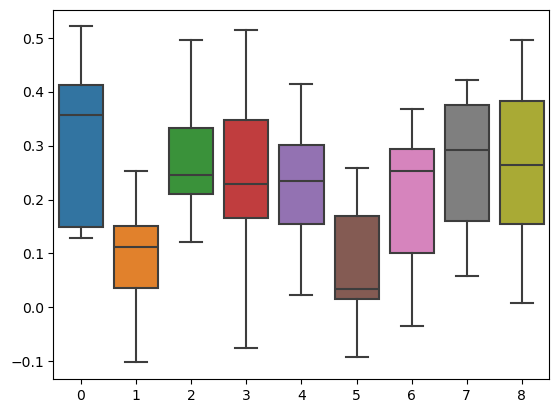

In [133]:
# Visualizer the distribution of the scores
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=y, y = X[:,7])

In [124]:
X[:,0]

array([0.70791485, 0.45526952, 0.72905111, 0.52623363, 0.34019107,
       0.27248674, 0.65610535, 0.57544779, 0.44289903, 0.57421443,
       0.38681289, 0.67934122, 0.65868852, 0.4877629 , 0.53407033,
       0.65803794, 0.61668769, 0.42446658, 0.50703486, 0.63520416,
       0.58782789, 0.64794838, 0.38378576, 0.61310991, 0.61047629,
       0.56100296, 0.65414645, 0.75479466, 0.45823981, 0.53979846,
       0.50870865, 0.5204777 , 0.35236077, 0.49906881, 0.59332269,
       0.5152705 , 0.50224378, 0.72429006, 0.69271413, 0.26422356,
       0.46537106, 0.51655527, 0.75340246, 0.67837602, 0.60231417,
       0.58275811, 0.4283998 , 0.46657137, 0.51273761, 0.39249077,
       0.46537469, 0.52130016, 0.32741616, 0.33395953, 0.42538276,
       0.48235378, 0.48374428, 0.37155131, 0.54694432, 0.5508159 ,
       0.5679977 , 0.57673173, 0.50664857, 0.47095022, 0.66407047,
       0.49822779, 0.26400604, 0.4016647 , 0.13441965, 0.39295805,
       0.41177476, 0.44530243])